In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tonlphc","key":"beed6ae78dc2f4db83cf6ea2e7c73495"}'}

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d mohamedmaher5/vehicle-classification
!unzip vehicle-classification.zip -d data_raw

Streaming output truncated to the last 5000 lines.
  inflating: data_raw/Vehicles/Auto Rickshaws/Auto Rickshaw (630).jpg  
  inflating: data_raw/Vehicles/Auto Rickshaws/Auto Rickshaw (631).jpg  
  inflating: data_raw/Vehicles/Auto Rickshaws/Auto Rickshaw (632).jpg  
  inflating: data_raw/Vehicles/Auto Rickshaws/Auto Rickshaw (633).jpg  
  inflating: data_raw/Vehicles/Auto Rickshaws/Auto Rickshaw (634).jpg  
  inflating: data_raw/Vehicles/Auto Rickshaws/Auto Rickshaw (635).jpg  
  inflating: data_raw/Vehicles/Auto Rickshaws/Auto Rickshaw (636).jpg  
  inflating: data_raw/Vehicles/Auto Rickshaws/Auto Rickshaw (637).jpg  
  inflating: data_raw/Vehicles/Auto Rickshaws/Auto Rickshaw (638).jpg  
  inflating: data_raw/Vehicles/Auto Rickshaws/Auto Rickshaw (639).jpg  
  inflating: data_raw/Vehicles/Auto Rickshaws/Auto Rickshaw (64).jpg  
  inflating: data_raw/Vehicles/Auto Rickshaws/Auto Rickshaw (640).jpg  
  inflating: data_raw/Vehicles/Auto Rickshaws/Auto Rickshaw (641).jpg  
  inflating: d

In [4]:
import os, shutil, random

src = "data_raw/Vehicles"
dst = "data"

splits = ["train", "val", "test"]
for s in splits:
    os.makedirs(os.path.join(dst, s), exist_ok=True)

for cls in os.listdir(src):
    cls_path = os.path.join(src, cls)
    if not os.path.isdir(cls_path):
        continue

    imgs = os.listdir(cls_path)
    random.shuffle(imgs)

    n = len(imgs)
    train_end = int(n * 0.8)
    val_end = int(n * 0.9)

    subsets = {
        "train": imgs[:train_end],
        "val": imgs[train_end:val_end],
        "test": imgs[val_end:]
    }

    for split, files in subsets.items():
        os.makedirs(os.path.join(dst, split, cls), exist_ok=True)
        for f in files:
            shutil.copy(os.path.join(cls_path, f),
                        os.path.join(dst, split, cls, f))

print("Done splitting dataset.")


Done splitting dataset.


In [5]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [6]:
BATCH_SIZE = 32

def fix_image(img):
    if img.mode == "P":  # palette
        img = img.convert("RGBA")
    if img.mode == "RGBA":
        img = img.convert("RGB")
    return img

train_tf = transforms.Compose([
    transforms.Lambda(fix_image), #fix image
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda image: image.convert('RGB')), #convert to RGB
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder("data/train", transform=train_tf)
val_ds   = datasets.ImageFolder("data/val",   transform=val_tf)
test_ds  = datasets.ImageFolder("data/test",  transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_ds.classes
print("Classes:", class_names)

Classes: ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']


In [7]:
BATCH_SIZE = 32

def fix_image(img):
    if img.mode == "P":  # palette
        img = img.convert("RGBA")
    if img.mode == "RGBA":
        img = img.convert("RGB")
    return img

train_tf = transforms.Compose([
    transforms.Lambda(fix_image), #fix image
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda image: image.convert('RGB')), #convert to RGB
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder("data/train", transform=train_tf)
val_ds   = datasets.ImageFolder("data/val",   transform=val_tf)
test_ds  = datasets.ImageFolder("data/test",  transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_ds.classes
print("Classes:", class_names)

Classes: ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']


In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = SimpleCNN(len(class_names)).to(DEVICE)
model


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [9]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

NUM_EPOCHS = 200 # Increased number of epochs
best_loss = float('inf')

# Early Stopping parameters
patience = 7 # Number of epochs to wait for improvement
counter = 0  # Counter for non-improving epochs
min_delta = 0.0001 # Minimum change to be considered an improvement

# Initialize lists to store metrics over epochs
train_losses_history = []
val_losses_history = []
train_accuracies_history = []
val_accuracies_history = []

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    total, correct, train_loss = 0, 0, 0
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
        _, preds = out.max(1)
        correct += (preds == y).sum().item()
        total += X.size(0)

    train_loss /= total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, val_correct, total_val = 0, 0, 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            out = model(X)
            loss = criterion(out, y)
            val_loss += loss.item() * X.size(0)
            _, preds = out.max(1)
            val_correct += (preds == y).sum().item()
            total_val += X.size(0)

    val_loss /= total_val
    val_acc = val_correct / total_val

    scheduler.step(val_loss)

    # Store metrics
    train_losses_history.append(train_loss)
    val_losses_history.append(val_loss)
    train_accuracies_history.append(train_acc)
    val_accuracies_history.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")

    # Save checkpoint and Early Stopping logic
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_cnn.pth")
        print("Saved best model!")
        counter = 0 # Reset counter if improvement is found
    else:
        counter += 1
        print(f"EarlyStopping counter: {counter} out of {patience}")
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


Epoch 1/200:  88%|████████▊ | 123/140 [00:59<00:06,  2.54it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/200: 100%|██████████| 140/140 [01:06<00:00,  2.09it/s]


Epoch 1: Train Loss=1.5689 Acc=0.3851 | Val Loss=1.2573 Acc=0.5259
Saved best model!


Epoch 2/200:  51%|█████▏    | 72/140 [00:34<00:25,  2.66it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2/200:  89%|████████▊ | 124/140 [00:55<00:06,  2.40it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2/200: 100%|██████████| 140/140 [01:03<00:00,  2.19it/s]


Epoch 2: Train Loss=1.2927 Acc=0.5075 | Val Loss=1.0066 Acc=0.6333
Saved best model!


Epoch 3/200:  30%|███       | 42/140 [00:19<00:38,  2.57it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3/200:  95%|█████████▌| 133/140 [01:00<00:03,  2.15it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3/200: 100%|██████████| 140/140 [01:03<00:00,  2.19it/s]


Epoch 3: Train Loss=1.2026 Acc=0.5480 | Val Loss=0.9554 Acc=0.6530
Saved best model!


Epoch 4/200:  47%|████▋     | 66/140 [00:29<00:26,  2.80it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4/200:  74%|███████▎  | 103/140 [00:46<00:22,  1.64it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4/200: 100%|██████████| 140/140 [01:04<00:00,  2.16it/s]


Epoch 4: Train Loss=1.1531 Acc=0.5744 | Val Loss=1.0788 Acc=0.5939
EarlyStopping counter: 1 out of 7


Epoch 5/200:  47%|████▋     | 66/140 [00:32<00:26,  2.82it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/200: 100%|██████████| 140/140 [01:05<00:00,  2.13it/s]


Epoch 5: Train Loss=1.1149 Acc=0.5923 | Val Loss=0.8569 Acc=0.6923
Saved best model!


Epoch 6/200:  33%|███▎      | 46/140 [00:21<00:37,  2.48it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 6/200: 100%|██████████| 140/140 [01:05<00:00,  2.15it/s]


Epoch 6: Train Loss=1.0573 Acc=0.6153 | Val Loss=0.7577 Acc=0.7549
Saved best model!


Epoch 7/200:  64%|██████▎   | 89/140 [00:42<00:20,  2.44it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7/200:  66%|██████▋   | 93/140 [00:43<00:17,  2.72it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7/200: 100%|██████████| 140/140 [01:04<00:00,  2.17it/s]


Epoch 7: Train Loss=1.0310 Acc=0.6225 | Val Loss=1.0368 Acc=0.6172
EarlyStopping counter: 1 out of 7


Epoch 8/200:  38%|███▊      | 53/140 [00:26<00:40,  2.16it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 8/200: 100%|██████████| 140/140 [01:04<00:00,  2.16it/s]


Epoch 8: Train Loss=0.9718 Acc=0.6439 | Val Loss=1.0751 Acc=0.6279
EarlyStopping counter: 2 out of 7


Epoch 9/200:  46%|████▌     | 64/140 [00:30<00:25,  2.99it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 9/200:  85%|████████▌ | 119/140 [00:55<00:07,  2.65it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 9/200: 100%|██████████| 140/140 [01:04<00:00,  2.19it/s]


Epoch 9: Train Loss=0.9945 Acc=0.6412 | Val Loss=0.6746 Acc=0.7674
Saved best model!


Epoch 10/200:  26%|██▌       | 36/140 [00:17<00:52,  2.00it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 10/200: 100%|██████████| 140/140 [01:03<00:00,  2.20it/s]


Epoch 10: Train Loss=0.9530 Acc=0.6623 | Val Loss=0.6538 Acc=0.7657
Saved best model!


Epoch 11/200:   9%|▉         | 13/140 [00:05<00:49,  2.56it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 11/200:  58%|█████▊    | 81/140 [00:37<00:17,  3.32it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 11/200: 100%|██████████| 140/140 [01:03<00:00,  2.19it/s]


Epoch 11: Train Loss=0.9067 Acc=0.6784 | Val Loss=0.8398 Acc=0.6798
EarlyStopping counter: 1 out of 7


Epoch 12/200:  94%|█████████▍| 132/140 [01:02<00:03,  2.14it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 12/200: 100%|██████████| 140/140 [01:04<00:00,  2.16it/s]


Epoch 12: Train Loss=0.8927 Acc=0.6728 | Val Loss=0.6128 Acc=0.7907
Saved best model!


Epoch 13/200:  44%|████▍     | 62/140 [00:29<00:29,  2.69it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 13/200: 100%|██████████| 140/140 [01:03<00:00,  2.21it/s]


Epoch 13: Train Loss=0.8925 Acc=0.6869 | Val Loss=0.5681 Acc=0.7835
Saved best model!


Epoch 14/200:  39%|███▊      | 54/140 [00:27<00:33,  2.57it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 14/200: 100%|██████████| 140/140 [01:03<00:00,  2.21it/s]


Epoch 14: Train Loss=0.8869 Acc=0.6869 | Val Loss=0.5770 Acc=0.8193
EarlyStopping counter: 1 out of 7


Epoch 15/200:   0%|          | 0/140 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 15/200:  69%|██████▊   | 96/140 [00:44<00:25,  1.71it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 15/200: 100%|██████████| 140/140 [01:04<00:00,  2.17it/s]


Epoch 15: Train Loss=0.8847 Acc=0.6757 | Val Loss=0.6112 Acc=0.7782
EarlyStopping counter: 2 out of 7


Epoch 16/200:  66%|██████▌   | 92/140 [00:41<00:18,  2.57it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 16/200:  75%|███████▌  | 105/140 [00:47<00:16,  2.15it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 16/200: 100%|██████████| 140/140 [01:04<00:00,  2.17it/s]


Epoch 16: Train Loss=0.8390 Acc=0.7003 | Val Loss=0.7613 Acc=0.7406
EarlyStopping counter: 3 out of 7


Epoch 17/200:  11%|█▏        | 16/140 [00:08<00:45,  2.72it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 17/200:  83%|████████▎ | 116/140 [00:53<00:10,  2.19it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 17/200: 100%|██████████| 140/140 [01:03<00:00,  2.20it/s]


Epoch 17: Train Loss=0.8266 Acc=0.7052 | Val Loss=0.5003 Acc=0.8247
Saved best model!


Epoch 18/200:  39%|███▉      | 55/140 [00:25<00:36,  2.35it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 18/200: 100%|██████████| 140/140 [01:03<00:00,  2.20it/s]


Epoch 18: Train Loss=0.8149 Acc=0.7189 | Val Loss=0.7385 Acc=0.7138
EarlyStopping counter: 1 out of 7


Epoch 19/200:   3%|▎         | 4/140 [00:01<00:43,  3.11it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 19/200: 100%|██████████| 140/140 [01:03<00:00,  2.19it/s]


Epoch 19: Train Loss=0.8131 Acc=0.7106 | Val Loss=0.6115 Acc=0.7764
EarlyStopping counter: 2 out of 7


Epoch 20/200:  49%|████▊     | 68/140 [00:31<00:28,  2.56it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 20/200:  55%|█████▌    | 77/140 [00:35<00:26,  2.39it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 20/200: 100%|██████████| 140/140 [01:02<00:00,  2.23it/s]


Epoch 20: Train Loss=0.8032 Acc=0.7171 | Val Loss=0.6908 Acc=0.7460
EarlyStopping counter: 3 out of 7


Epoch 21/200:  29%|██▊       | 40/140 [00:19<00:38,  2.63it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 21/200:  39%|███▊      | 54/140 [00:26<00:35,  2.45it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 21/200: 100%|██████████| 140/140 [01:03<00:00,  2.21it/s]


Epoch 21: Train Loss=0.7944 Acc=0.7186 | Val Loss=0.5501 Acc=0.8211
EarlyStopping counter: 4 out of 7


Epoch 22/200:  26%|██▌       | 36/140 [00:16<00:35,  2.89it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 22/200:  88%|████████▊ | 123/140 [00:58<00:08,  1.90it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 22/200: 100%|██████████| 140/140 [01:04<00:00,  2.19it/s]


Epoch 22: Train Loss=0.7220 Acc=0.7423 | Val Loss=0.4025 Acc=0.8623
Saved best model!


Epoch 23/200:  28%|██▊       | 39/140 [00:18<00:32,  3.15it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 23/200: 100%|██████████| 140/140 [01:03<00:00,  2.22it/s]


Epoch 23: Train Loss=0.7143 Acc=0.7502 | Val Loss=0.3954 Acc=0.8676
Saved best model!


Epoch 24/200:  11%|█         | 15/140 [00:07<01:42,  1.22it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 24/200:  74%|███████▍  | 104/140 [00:47<00:21,  1.71it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 24/200: 100%|██████████| 140/140 [01:02<00:00,  2.24it/s]


Epoch 24: Train Loss=0.6871 Acc=0.7602 | Val Loss=0.3707 Acc=0.8694
Saved best model!


Epoch 25/200:  45%|████▌     | 63/140 [00:28<00:40,  1.90it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 25/200:  64%|██████▎   | 89/140 [00:39<00:17,  2.91it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 25/200: 100%|██████████| 140/140 [01:02<00:00,  2.22it/s]


Epoch 25: Train Loss=0.6707 Acc=0.7672 | Val Loss=0.3798 Acc=0.8730
EarlyStopping counter: 1 out of 7


Epoch 26/200:  70%|███████   | 98/140 [00:44<00:22,  1.83it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 26/200:  80%|████████  | 112/140 [00:51<00:15,  1.81it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 26/200: 100%|██████████| 140/140 [01:02<00:00,  2.23it/s]


Epoch 26: Train Loss=0.6601 Acc=0.7636 | Val Loss=0.3624 Acc=0.8605
Saved best model!


Epoch 27/200:  56%|█████▋    | 79/140 [00:38<00:22,  2.76it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 27/200:  71%|███████   | 99/140 [00:47<00:20,  1.97it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 27/200: 100%|██████████| 140/140 [01:03<00:00,  2.19it/s]


Epoch 27: Train Loss=0.6655 Acc=0.7591 | Val Loss=0.3517 Acc=0.8748
Saved best model!


Epoch 28/200:   0%|          | 0/140 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 28/200: 100%|██████████| 140/140 [01:03<00:00,  2.22it/s]


Epoch 28: Train Loss=0.6661 Acc=0.7607 | Val Loss=0.3600 Acc=0.8748
EarlyStopping counter: 1 out of 7


Epoch 29/200:  24%|██▎       | 33/140 [00:15<00:49,  2.17it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 29/200:  90%|█████████ | 126/140 [00:57<00:03,  3.55it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 29/200: 100%|██████████| 140/140 [01:04<00:00,  2.18it/s]


Epoch 29: Train Loss=0.6708 Acc=0.7649 | Val Loss=0.3562 Acc=0.8569
EarlyStopping counter: 2 out of 7


Epoch 30/200:   0%|          | 0/140 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 30/200: 100%|██████████| 140/140 [01:03<00:00,  2.20it/s]


Epoch 30: Train Loss=0.6746 Acc=0.7649 | Val Loss=0.3582 Acc=0.8766
EarlyStopping counter: 3 out of 7


Epoch 31/200:  34%|███▎      | 47/140 [00:21<00:52,  1.76it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 31/200:  80%|████████  | 112/140 [00:50<00:09,  2.88it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 31/200: 100%|██████████| 140/140 [01:03<00:00,  2.20it/s]


Epoch 31: Train Loss=0.6395 Acc=0.7748 | Val Loss=0.3441 Acc=0.8766
Saved best model!


Epoch 32/200:  60%|██████    | 84/140 [00:39<00:15,  3.59it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 32/200: 100%|██████████| 140/140 [01:02<00:00,  2.23it/s]


Epoch 32: Train Loss=0.6693 Acc=0.7685 | Val Loss=0.3454 Acc=0.8712
EarlyStopping counter: 1 out of 7


Epoch 33/200:  44%|████▍     | 62/140 [00:28<00:34,  2.26it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 33/200: 100%|██████████| 140/140 [01:03<00:00,  2.21it/s]


Epoch 33: Train Loss=0.6508 Acc=0.7716 | Val Loss=0.3425 Acc=0.8766
Saved best model!


Epoch 34/200:  21%|██▏       | 30/140 [00:13<00:47,  2.33it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 34/200: 100%|██████████| 140/140 [01:03<00:00,  2.19it/s]


Epoch 34: Train Loss=0.6410 Acc=0.7725 | Val Loss=0.3430 Acc=0.8748
EarlyStopping counter: 1 out of 7


Epoch 35/200:  39%|███▊      | 54/140 [00:25<00:29,  2.93it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 35/200:  48%|████▊     | 67/140 [00:32<00:34,  2.10it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 35/200: 100%|██████████| 140/140 [01:03<00:00,  2.21it/s]


Epoch 35: Train Loss=0.6367 Acc=0.7781 | Val Loss=0.3647 Acc=0.8623
EarlyStopping counter: 2 out of 7


Epoch 36/200:  94%|█████████▍| 132/140 [01:00<00:02,  3.21it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 36/200: 100%|██████████| 140/140 [01:03<00:00,  2.21it/s]


Epoch 36: Train Loss=0.6253 Acc=0.7781 | Val Loss=0.3290 Acc=0.8766
Saved best model!


Epoch 37/200:  12%|█▏        | 17/140 [00:06<00:49,  2.50it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 37/200:  26%|██▋       | 37/140 [00:15<00:35,  2.91it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 37/200: 100%|██████████| 140/140 [01:03<00:00,  2.21it/s]


Epoch 37: Train Loss=0.6276 Acc=0.7864 | Val Loss=0.3404 Acc=0.8801
EarlyStopping counter: 1 out of 7


Epoch 38/200:  57%|█████▋    | 80/140 [00:36<00:21,  2.85it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 38/200: 100%|██████████| 140/140 [01:03<00:00,  2.19it/s]


Epoch 38: Train Loss=0.6345 Acc=0.7775 | Val Loss=0.3415 Acc=0.8748
EarlyStopping counter: 2 out of 7


Epoch 39/200:  19%|█▉        | 27/140 [00:11<01:04,  1.76it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 39/200: 100%|██████████| 140/140 [01:04<00:00,  2.17it/s]


Epoch 39: Train Loss=0.6255 Acc=0.7813 | Val Loss=0.3247 Acc=0.8801
Saved best model!


Epoch 40/200:  86%|████████▋ | 121/140 [00:57<00:06,  2.93it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 40/200: 100%|██████████| 140/140 [01:03<00:00,  2.19it/s]


Epoch 40: Train Loss=0.6124 Acc=0.7871 | Val Loss=0.3081 Acc=0.8819
Saved best model!


Epoch 41/200:  50%|█████     | 70/140 [00:31<00:36,  1.93it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 41/200: 100%|██████████| 140/140 [01:03<00:00,  2.20it/s]


Epoch 41: Train Loss=0.6245 Acc=0.7819 | Val Loss=0.3057 Acc=0.8801
Saved best model!


Epoch 42/200:  49%|████▉     | 69/140 [00:32<00:34,  2.04it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 42/200: 100%|██████████| 140/140 [01:04<00:00,  2.17it/s]


Epoch 42: Train Loss=0.6130 Acc=0.7918 | Val Loss=0.3101 Acc=0.8855
EarlyStopping counter: 1 out of 7


Epoch 43/200:   7%|▋         | 10/140 [00:04<00:49,  2.63it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 43/200: 100%|██████████| 140/140 [01:03<00:00,  2.21it/s]


Epoch 43: Train Loss=0.6255 Acc=0.7855 | Val Loss=0.3197 Acc=0.8891
EarlyStopping counter: 2 out of 7


Epoch 44/200:  16%|█▋        | 23/140 [00:10<00:39,  2.98it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 44/200:  38%|███▊      | 53/140 [00:24<00:42,  2.05it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 44/200: 100%|██████████| 140/140 [01:03<00:00,  2.20it/s]


Epoch 44: Train Loss=0.6288 Acc=0.7768 | Val Loss=0.3179 Acc=0.8766
EarlyStopping counter: 3 out of 7


Epoch 45/200:  94%|█████████▍| 132/140 [01:00<00:02,  3.34it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 45/200: 100%|██████████| 140/140 [01:03<00:00,  2.22it/s]


Epoch 45: Train Loss=0.6153 Acc=0.7877 | Val Loss=0.3153 Acc=0.8784
EarlyStopping counter: 4 out of 7


Epoch 46/200:  25%|██▌       | 35/140 [00:15<01:00,  1.74it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 46/200: 100%|██████████| 140/140 [01:03<00:00,  2.20it/s]


Epoch 46: Train Loss=0.6065 Acc=0.7886 | Val Loss=0.3090 Acc=0.8855
EarlyStopping counter: 5 out of 7


Epoch 47/200:   0%|          | 0/140 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 47/200:  95%|█████████▌| 133/140 [00:59<00:01,  4.11it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 47/200: 100%|██████████| 140/140 [01:03<00:00,  2.22it/s]


Epoch 47: Train Loss=0.5962 Acc=0.7933 | Val Loss=0.2995 Acc=0.8819
Saved best model!


Epoch 48/200:  48%|████▊     | 67/140 [00:31<00:37,  1.94it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 48/200: 100%|██████████| 140/140 [01:03<00:00,  2.22it/s]


Epoch 48: Train Loss=0.6001 Acc=0.7922 | Val Loss=0.2967 Acc=0.8891
Saved best model!


Epoch 49/200:   6%|▋         | 9/140 [00:04<01:04,  2.04it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 49/200: 100%|██████████| 140/140 [01:02<00:00,  2.23it/s]


Epoch 49: Train Loss=0.5879 Acc=0.7947 | Val Loss=0.2966 Acc=0.8837
Saved best model!


Epoch 50/200:  60%|██████    | 84/140 [00:38<00:22,  2.45it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 50/200: 100%|██████████| 140/140 [01:03<00:00,  2.20it/s]


Epoch 50: Train Loss=0.5955 Acc=0.7893 | Val Loss=0.2993 Acc=0.8837
EarlyStopping counter: 1 out of 7


Epoch 51/200:   4%|▎         | 5/140 [00:03<01:19,  1.70it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 51/200:  33%|███▎      | 46/140 [00:20<00:46,  2.03it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 51/200: 100%|██████████| 140/140 [01:02<00:00,  2.23it/s]


Epoch 51: Train Loss=0.5682 Acc=0.7958 | Val Loss=0.2936 Acc=0.8873
Saved best model!


Epoch 52/200:  31%|███       | 43/140 [00:22<00:36,  2.66it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 52/200: 100%|██████████| 140/140 [01:03<00:00,  2.20it/s]


Epoch 52: Train Loss=0.5740 Acc=0.7967 | Val Loss=0.3049 Acc=0.8819
EarlyStopping counter: 1 out of 7


Epoch 53/200:  21%|██▏       | 30/140 [00:12<00:33,  3.33it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 53/200:  43%|████▎     | 60/140 [00:27<00:36,  2.18it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 53/200: 100%|██████████| 140/140 [01:02<00:00,  2.23it/s]


Epoch 53: Train Loss=0.5967 Acc=0.7902 | Val Loss=0.2946 Acc=0.8855
EarlyStopping counter: 2 out of 7


Epoch 54/200:   2%|▏         | 3/140 [00:01<01:11,  1.91it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 54/200:   4%|▎         | 5/140 [00:02<01:04,  2.09it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 54/200: 100%|██████████| 140/140 [01:03<00:00,  2.22it/s]


Epoch 54: Train Loss=0.5652 Acc=0.7994 | Val Loss=0.2946 Acc=0.8855
EarlyStopping counter: 3 out of 7


Epoch 55/200:  47%|████▋     | 66/140 [00:29<00:35,  2.06it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 55/200:  50%|█████     | 70/140 [00:31<00:27,  2.59it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 55/200: 100%|██████████| 140/140 [01:02<00:00,  2.23it/s]


Epoch 55: Train Loss=0.5929 Acc=0.7940 | Val Loss=0.2949 Acc=0.8819
EarlyStopping counter: 4 out of 7


Epoch 56/200:  29%|██▉       | 41/140 [00:18<00:47,  2.10it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 56/200: 100%|██████████| 140/140 [01:04<00:00,  2.19it/s]


Epoch 56: Train Loss=0.5848 Acc=0.7978 | Val Loss=0.2952 Acc=0.8873
EarlyStopping counter: 5 out of 7


Epoch 57/200:  24%|██▍       | 34/140 [00:16<00:52,  2.03it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 57/200: 100%|██████████| 140/140 [01:03<00:00,  2.21it/s]


Epoch 57: Train Loss=0.5927 Acc=0.7947 | Val Loss=0.2971 Acc=0.8891
EarlyStopping counter: 6 out of 7


Epoch 58/200:  12%|█▏        | 17/140 [00:08<01:06,  1.86it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 58/200:  54%|█████▍    | 76/140 [00:35<00:26,  2.44it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 58/200: 100%|██████████| 140/140 [01:03<00:00,  2.19it/s]


Epoch 58: Train Loss=0.5700 Acc=0.8012 | Val Loss=0.2980 Acc=0.8837
EarlyStopping counter: 7 out of 7
Early stopping triggered after 58 epochs.


In [10]:
model.load_state_dict(torch.load("best_cnn.pth"))
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(DEVICE)
        out = model(X)
        preds = out.argmax(1).cpu().numpy()
        pred_labels.extend(preds)
        true_labels.extend(y.numpy())

from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels, target_names=class_names))


                precision    recall  f1-score   support

Auto Rickshaws       0.91      0.88      0.89        80
         Bikes       1.00      0.95      0.97        80
          Cars       0.86      0.95      0.90        79
   Motorcycles       0.89      0.93      0.91        80
        Planes       0.95      0.95      0.95        80
         Ships       0.95      0.88      0.91        80
        Trains       0.87      0.89      0.88        80

      accuracy                           0.92       559
     macro avg       0.92      0.92      0.92       559
  weighted avg       0.92      0.92      0.92       559



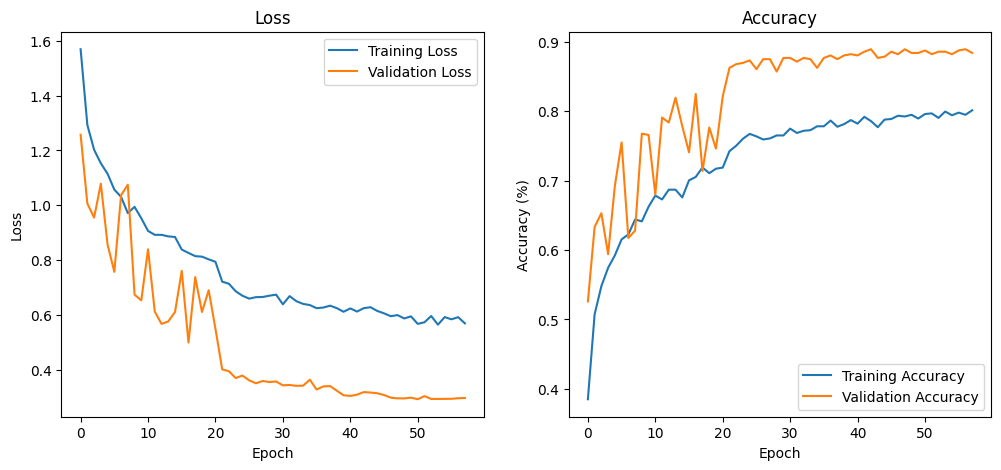

In [11]:
import matplotlib.pyplot as plt

# plot loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses_history, label='Training Loss')
plt.plot(val_losses_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# plot accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies_history, label='Training Accuracy')
plt.plot(val_accuracies_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

plt.show()